# Title - Milestone I

## 1) Import dependencies

### 1a) Install requirments.txt

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

### 1b) Import libraries

In [2]:
import os

import pandas as pd
from pyspark.sql import SparkSession
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display
from PIL import Image

In [3]:
from src.zip_streaming import zip_streaming
from src.parcel_partition_write import parcel_partition_write
from src.parcel_partition_read import parcel_partition_read

from src.district_location import get_district_location
from src.school_location import get_school_location

from src.district_score import get_district_score
from src.school_score import get_school_score

from src.render_plot import render_plot

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

### 1b) Notebook toggles

In [5]:
regenerate_tables = False
regenerate_charts = False
random_state = 42

## 2) Run data pipeline

### 2a) Run CoreLogic data pipeline

In [6]:
required_files = ['resources/data/df_parcel.pkl']

partition_column = "PROPERTY INDICATOR CODE"
partition_value = "10"

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    df_parcel = pd.read_pickle("resources/data/df_parcel.pkl")

else:
    print("🚀 Required files not found. Running initial run...")

    ## Unzip and slice the orignal coreLogic dataset
    zip_streaming(zip_file_path = 'resources/data/coreLogic.zip', 
                 file_name_in_zip = 'coreLogic.txt',
                 output_path = 'resources/data/filtered_core_logic.txt',
                 chunk_size = 10000,
                 state = 'MI')

    ## Partition the coreLogic slice using Spark
    parcel_partition_write(input_file = 'resources/data/filtered_core_logic.txt', 
                           partition_column = partition_column)

    ## Load selected partition into Pandas DataFrame and format as GeoDataFrame
    df_parcel = parcel_partition_read(partition_folder = f"resources/data/parition_{partition_column}",
                                     partition_value = partition_value,
                                     pkl_path = 'resources/data/df_parcel.pkl',
                                     pkl_save = True)

    print("✅ Initial run complete. Required files should now be saved.")


✅ Required files found. Running secondary run...


### 2b) Run education score data pipeline

In [7]:
required_files = ['resources/data/df_school_score.csv', 'resources/data/df_district_score.csv']
input_files = {'atrisk':'resources/data/At Risk Student file for Statewide, school year 2020-21.csv',
               'enrollment':'resources/data/College Enrollment by High School & 24 College Credits file for Statewide, school year 2020-21.csv',
               'assessment':'resources/data/High School Assessments file for Statewide, school year 2020-21.csv', 
               'effectiveness':'resources/data/Educator Effectiveness file for Statewide, school year 2020-21.csv'}

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    df_school_score = pd.read_csv("resources/data/df_school_score.csv")
    df_district_score = pd.read_csv("resources/data/df_district_score.csv")

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")

    df_school_score = get_school_score(enrollment = input_files['enrollment'], 
                                       assessment  = input_files['assessment'],
                                       effectiveness  = input_files['effectiveness'],
                                       csv_path = 'resources/data/df_school_score.csv',
                                       csv_save = True)
    df_district_score = get_district_score(atrisk = input_files['atrisk'],
                                           enrollment = input_files['enrollment'],
                                           assessment = input_files['assessment'],
                                           csv_path = 'resources/data/df_district_score.csv',
                                           csv_save = True)

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")



✅ Required files found. Running secondary run...


### 2c) Run location data pipeline

In [8]:
required_files = ['resources/data/district_location.pkl', 'resources/data/school_location.pkl']
input_files = {'district_shapefile':"resources/data/school_district_map/School_District.shp"}

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    df_district_location = pd.read_pickle("resources/data/district_location.pkl")
    df_school_location = pd.read_pickle("resources/data/school_location.pkl")

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")

    df_district_location = get_district_location(shapefile_path = input_files['district_shapefile'],
                                                 pkl_save = True, 
                                                 pkl_path = 'resources/data/district_location.pkl')
    df_school_location = get_school_location(pkl_save = True, 
                                             pkl_path = 'resources/data/school_location.pkl')

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")

✅ Required files found. Running secondary run...


### 2d) Table joins

In [12]:
required_files = ['resources/data/df_parcel_joined.pkl','resources/data/df_school_joined.pkl','resources/data/df_district_joined.pkl']

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    df_school_joined = pd.read_pickle('resources/data/df_school_joined.pkl')
    df_district_joined = pd.read_pickle('resources/data/df_district_joined.pkl')
    df_parcel_joined = pd.read_pickle('resources/data/df_parcel_joined.pkl')

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")
    df_school_joined = df_school_location.merge(df_school_score, on='school_code', how='inner', suffixes=('', '_y')).drop(['school_name_y'],  axis=1)
    df_district_joined = df_district_location.merge(df_district_score, on='district_code', how='inner', suffixes=('', '_y'))
    df_parcel_joined = gpd.sjoin_nearest(df_parcel, df_school_joined, how="left", distance_col="distance")
    df_parcel_joined = gpd.sjoin(df_parcel_joined, df_district_joined, predicate="within", how="left", lsuffix='school', rsuffix='dist')
    
    df_school_joined.to_pickle('resources/data/df_school_joined.pkl')
    df_district_joined.to_pickle('resources/data/df_district_joined.pkl')
    df_parcel_joined.to_pickle('resources/data/df_parcel_joined.pkl')

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")

✅ Required files found. Running secondary run...


## 3) Data wrangling & exploratory analysis

### 3z) Spatial check

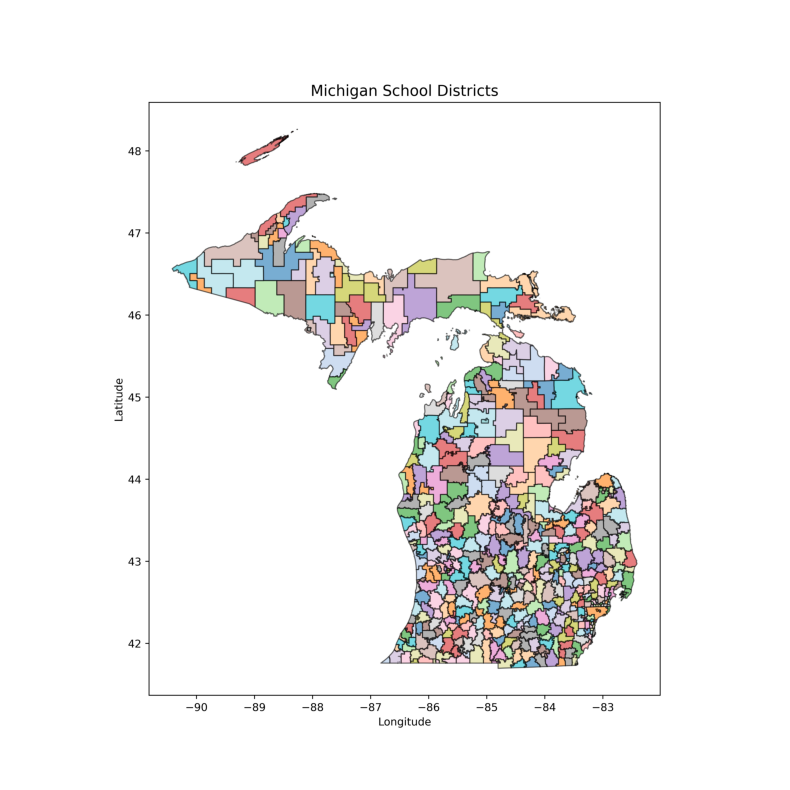

In [9]:
chart_name = "resources/charts/michigan_school_districts.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor='black', cmap='tab20', alpha=0.6)
    
    ax.set_title("Michigan School Districts", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
    fig.savefig(chart_name, dpi=500)


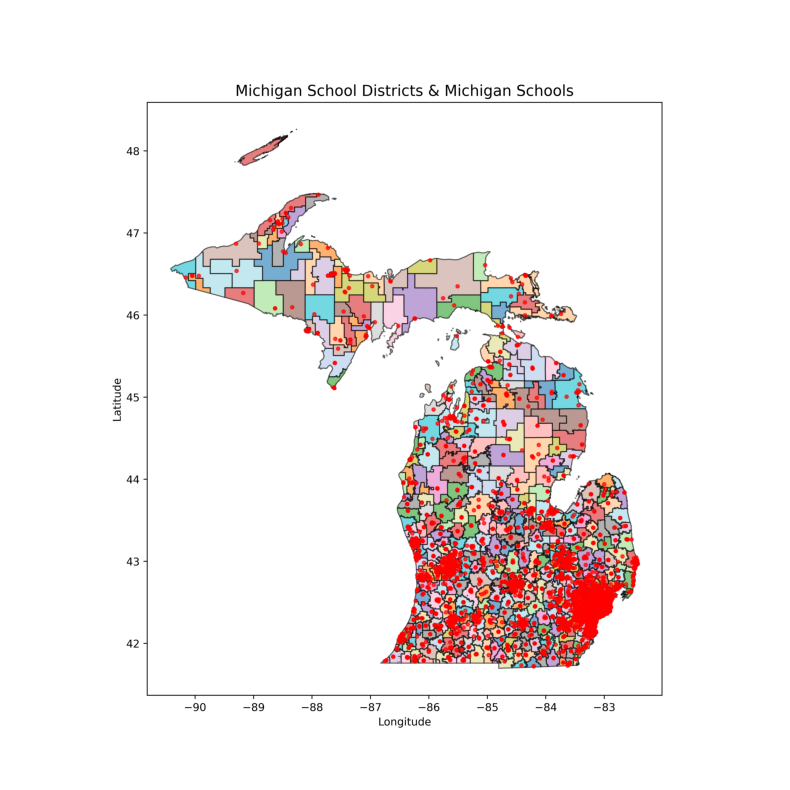

In [10]:
chart_name = "resources/charts/michigan_school_districts_and_schools.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.6)
    df_school_location.plot(
        ax=ax, marker="o", color="red", markersize=10, alpha=0.7, label="Schools"
    )
    ax.set_title("Michigan School Districts & Michigan Schools", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
    fig.savefig(chart_name, dpi=500)


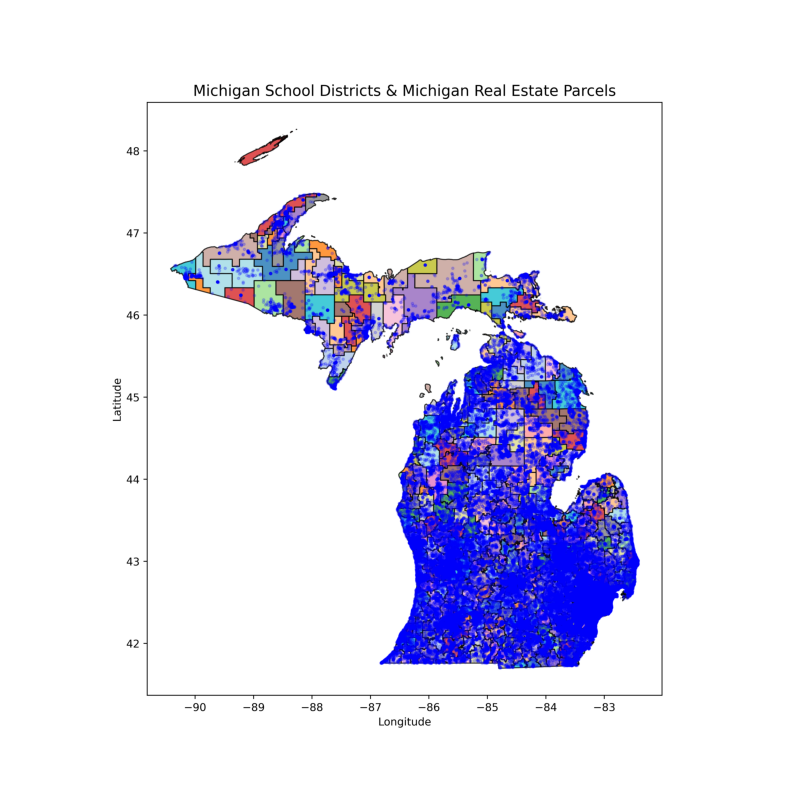

In [11]:
chart_name = "resources/charts/michigan_school_districts_and_parcels.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel.sample(n = 100000, random_state = random_state).plot(
        ax=ax, marker="o", color="blue", markersize=5, alpha=0.2, label="Schools"
    )
    
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    plt.show()
    fig.savefig(chart_name, dpi=500)


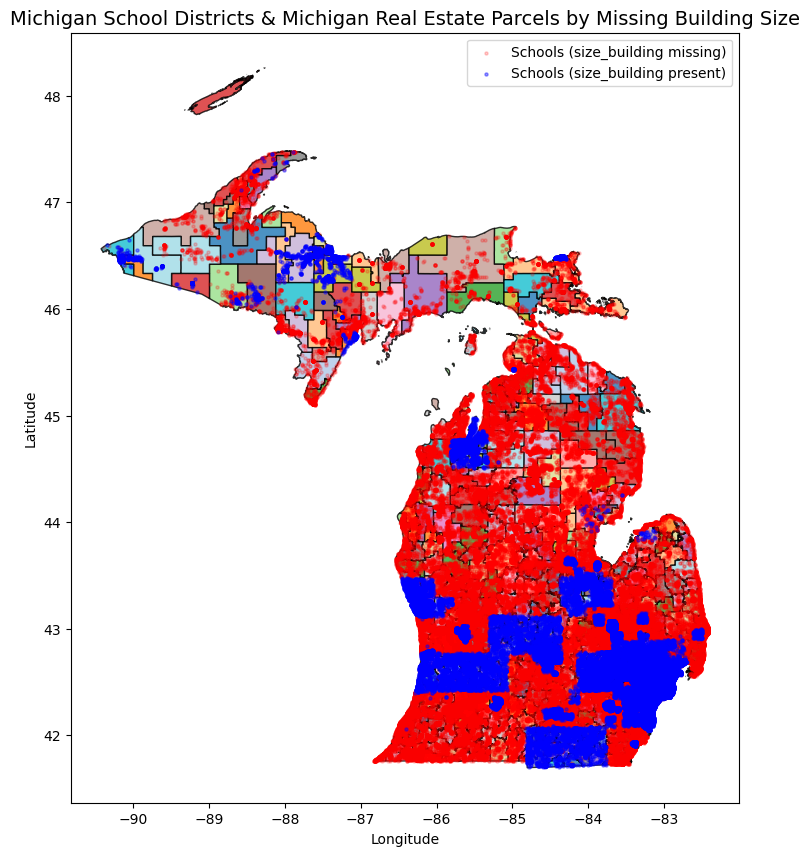

In [48]:
chart_name = "resources/charts/df_parcel_missing_building_size.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel_joined[df_parcel_joined['size_building'].isna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="red", markersize=5, alpha=0.2, label="Schools (size_building missing)")
    df_parcel_joined[df_parcel_joined['size_building'].notna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="blue", markersize=5, alpha=0.4, label="Schools (size_building present)")
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels by Missing Building Size", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()
    fig.savefig(chart_name, dpi=500)

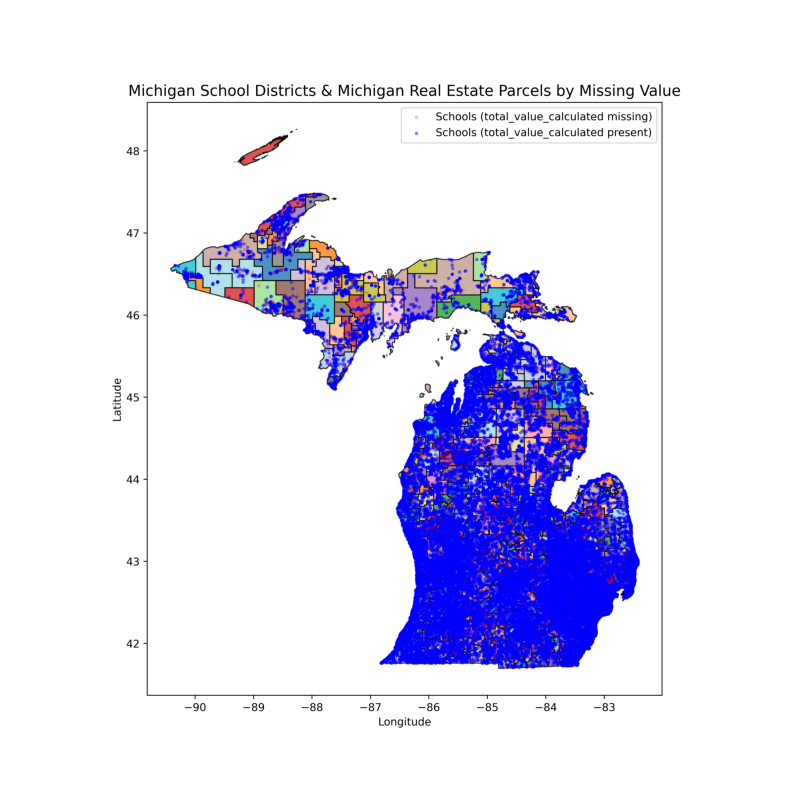

In [52]:
chart_name = "resources/charts/df_parcel_missing_value.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel_joined[df_parcel_joined['total_value_calculated'].notna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="blue", markersize=5, alpha=0.1, label="Schools (total_value_calculated present)")
    df_parcel_joined[df_parcel_joined['total_value_calculated'].isna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="red", markersize=5, alpha=1, label="Schools (total_value_calculated missing)")
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels by Missing Value", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()
    fig.savefig(chart_name, dpi=500)

### 3a) Missing values & Imputation

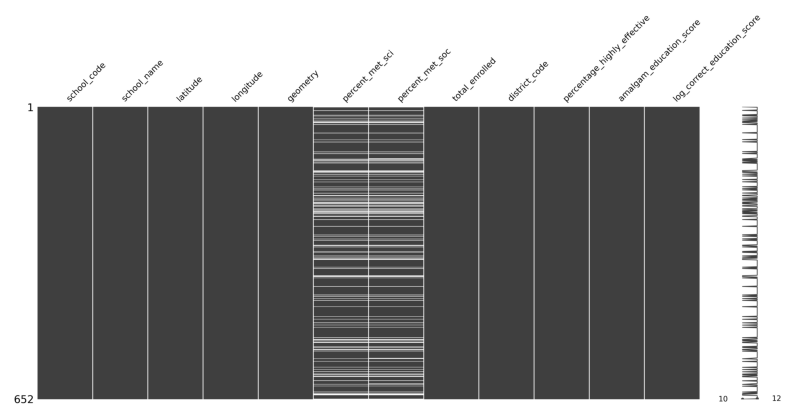

In [26]:
chart_name = "resources/charts/df_school_missing_data_matrix.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig = msno.matrix(df_school_joined)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()


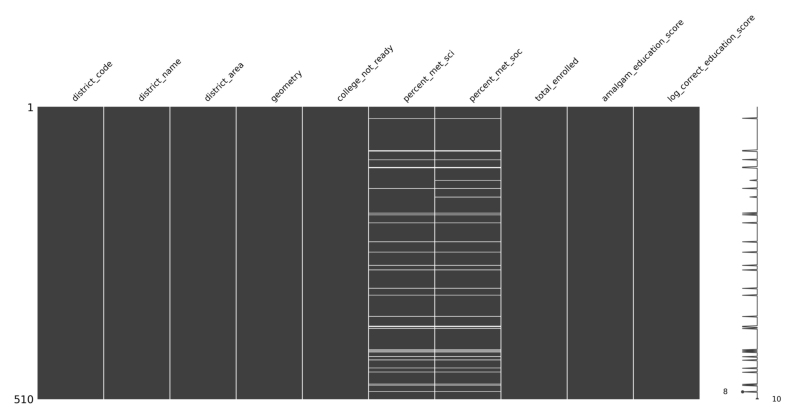

In [27]:
chart_name = "resources/charts/df_district_missing_data_matrix.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig = msno.matrix(df_district_joined)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

<Axes: >

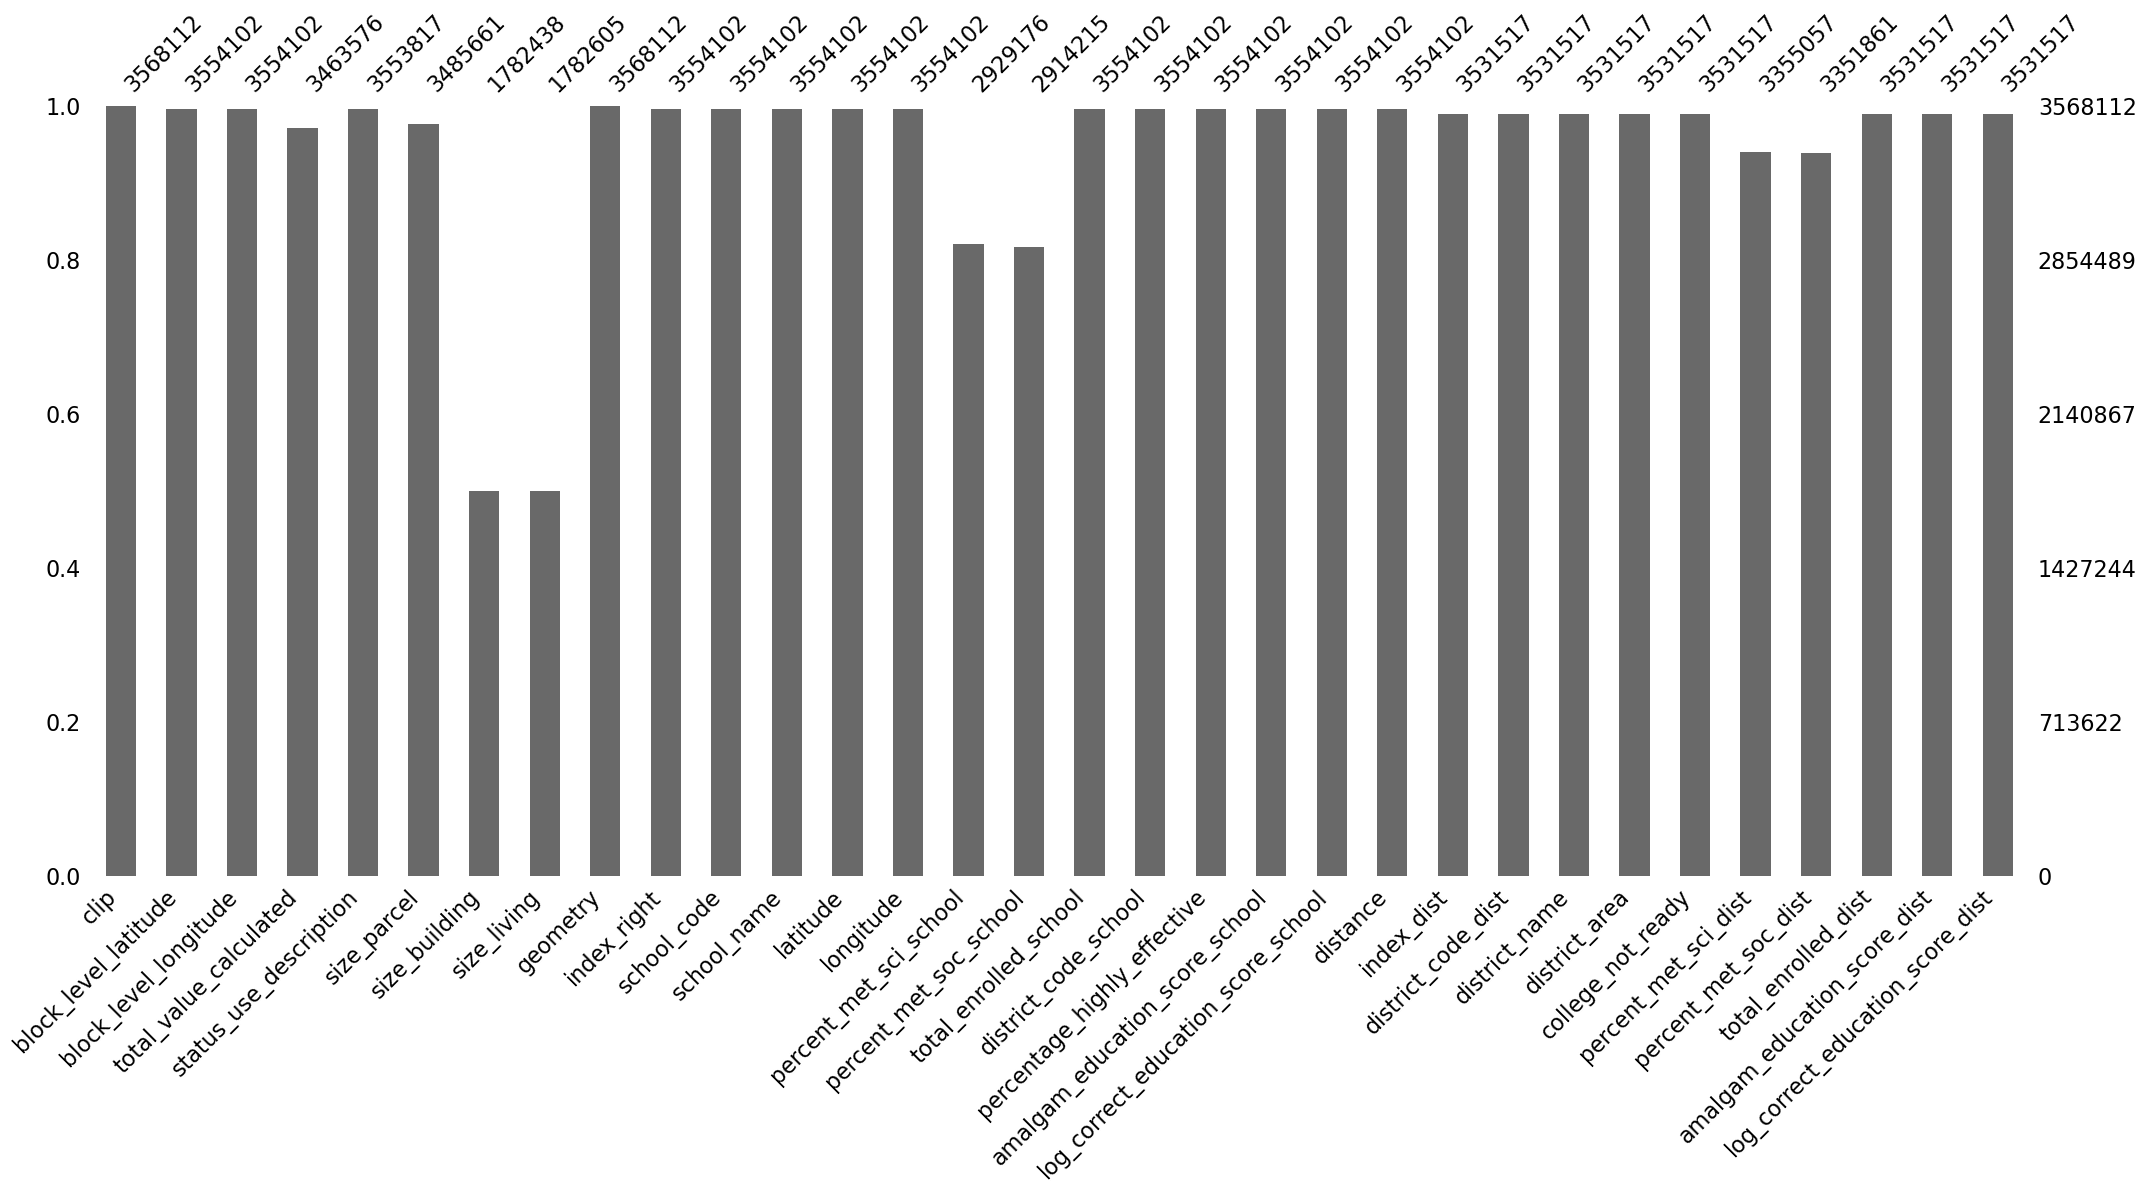

In [49]:
msno.bar(df_parcel_joined) 

<Axes: >

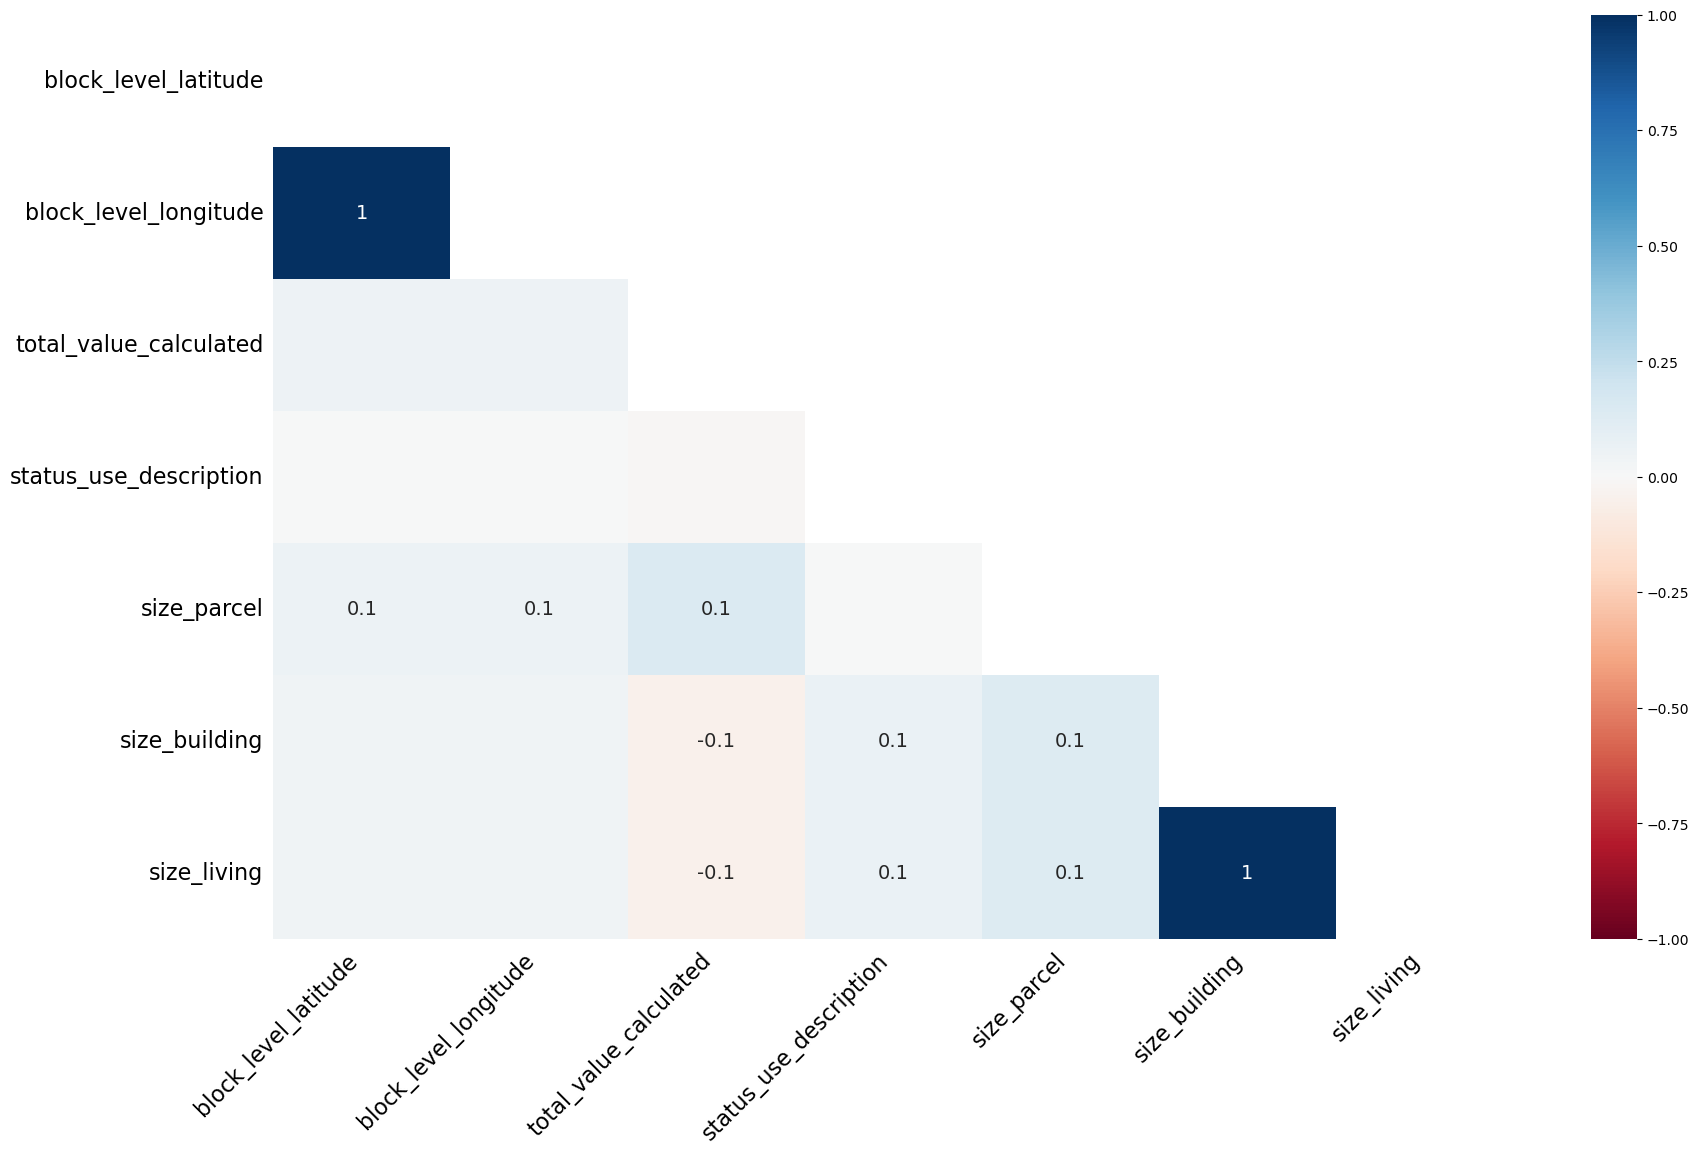

In [43]:
msno.heatmap(df_parcel) 

### 3b) Variable distributions

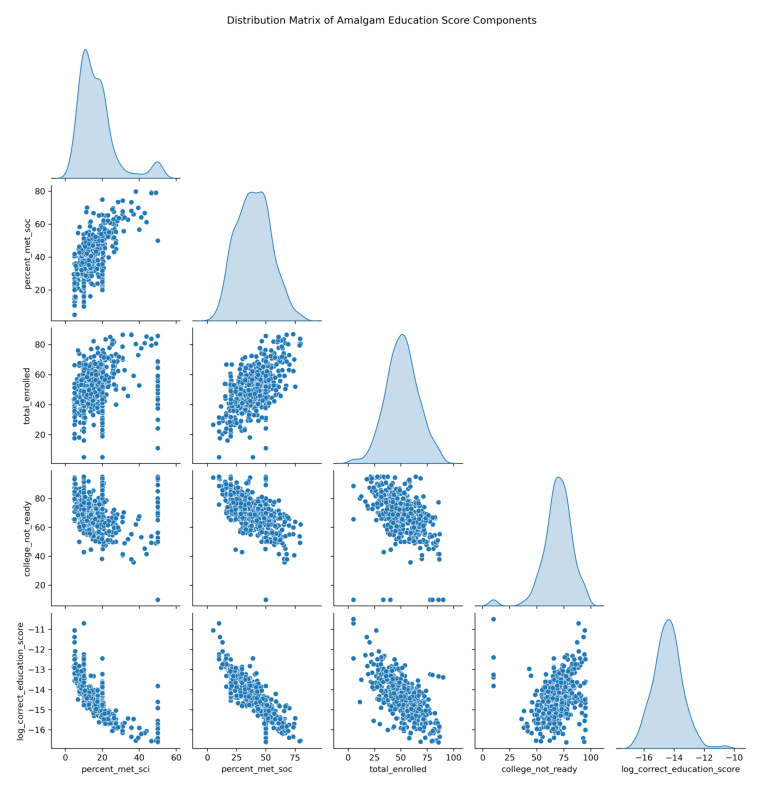

In [28]:
chart_name = "resources/charts/df_district_pairplot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    columns_to_plot = ['percent_met_sci', 'percent_met_soc', 'total_enrolled', 'college_not_ready','log_correct_education_score']
    sns.pairplot(df_district_joined[columns_to_plot], diag_kind='kde', corner=True)
    plt.suptitle("Distribution Matrix of Amalgam Education Score Components", y=1.02)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

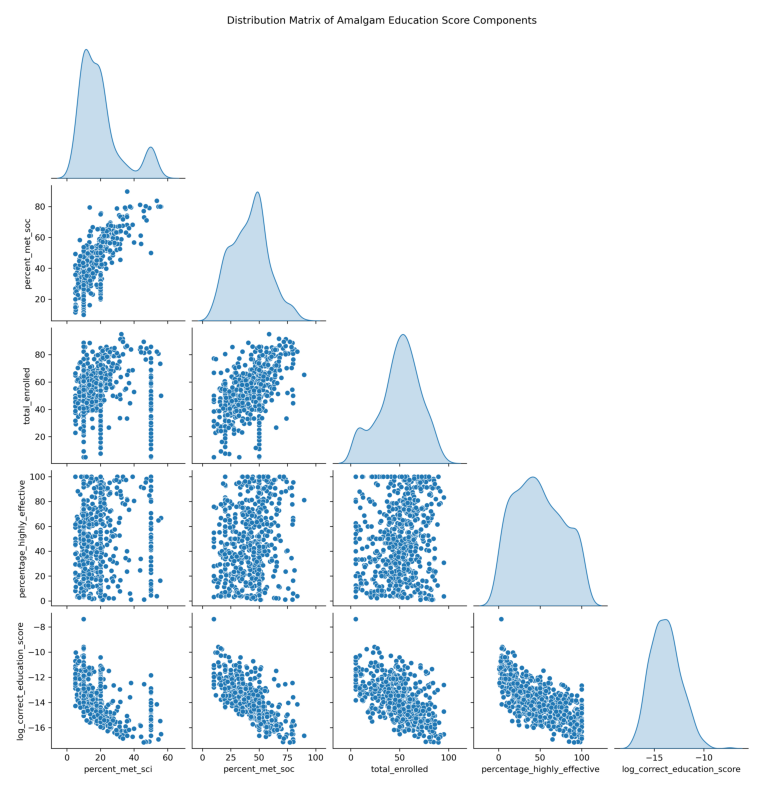

In [29]:
chart_name = "resources/charts/df_school_pairplot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    columns_to_plot = ['percent_met_sci', 'percent_met_soc', 'total_enrolled', 'percentage_highly_effective','log_correct_education_score']
    sns.pairplot(df_school_joined[columns_to_plot], diag_kind='kde', corner=True)
    plt.suptitle("Distribution Matrix of Amalgam Education Score Components", y=1.02)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

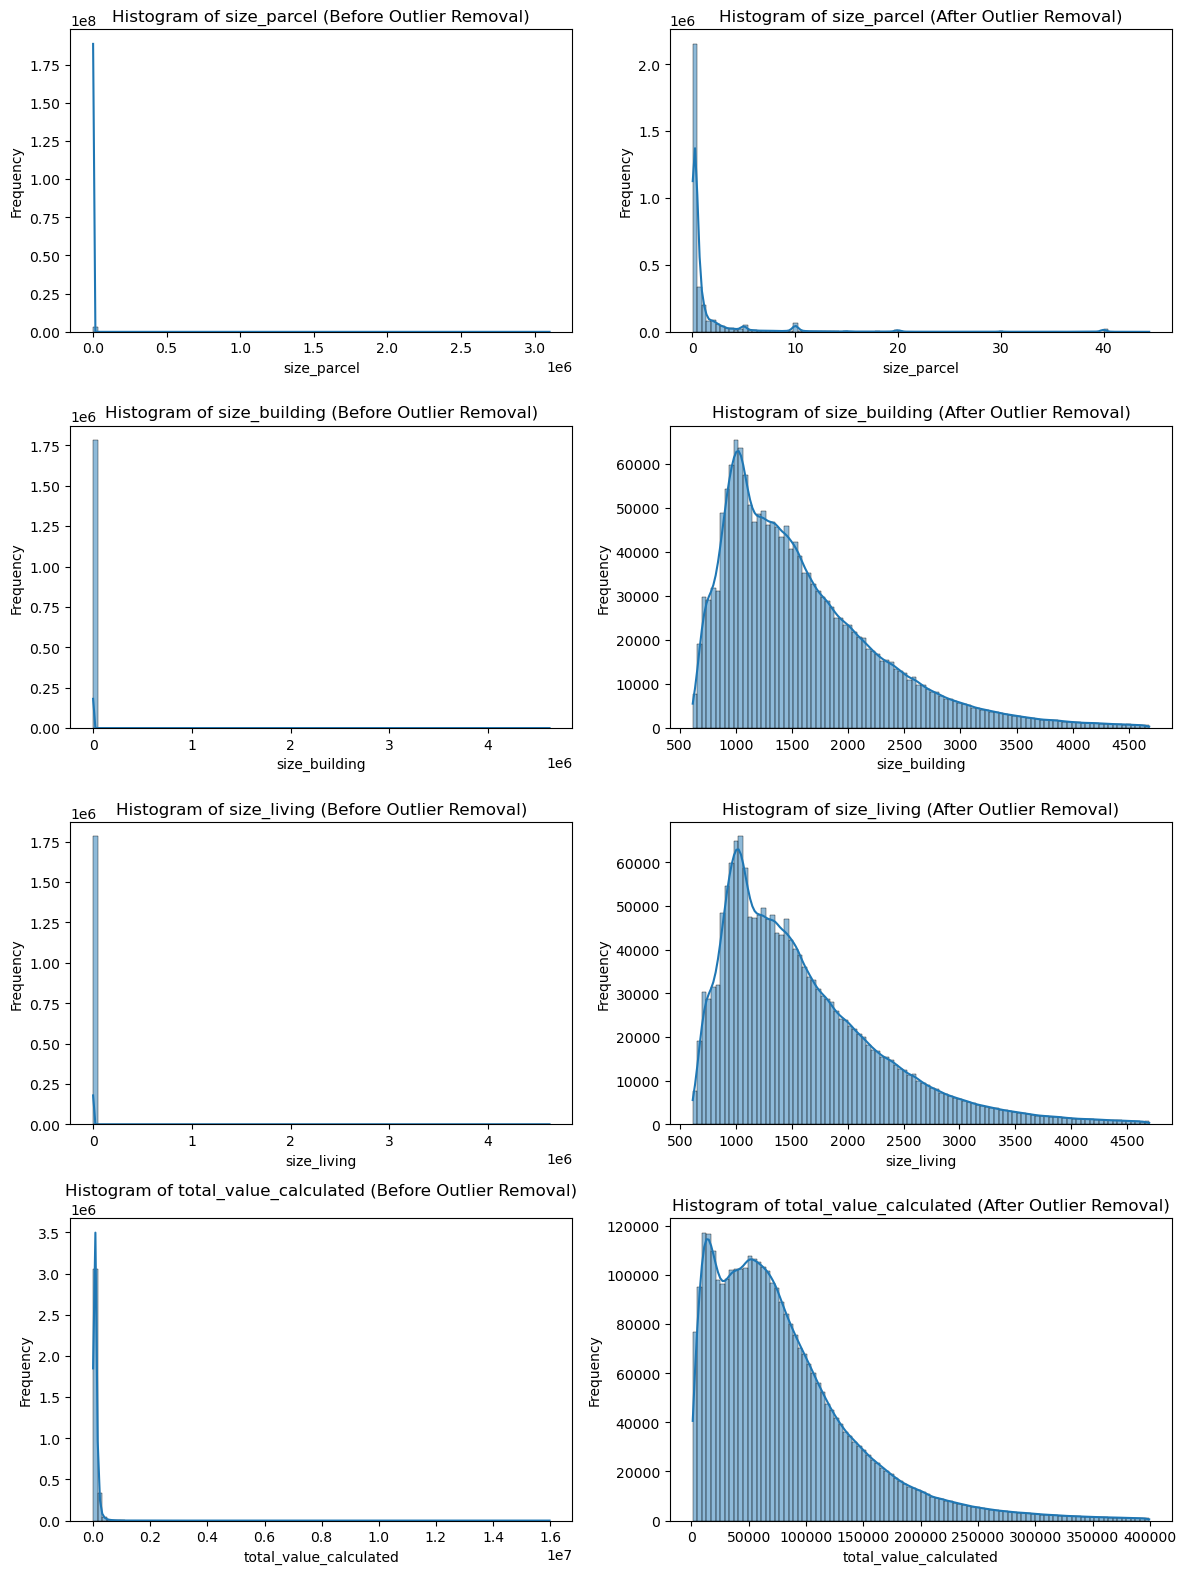

In [79]:
chart_name = "resources/charts/df_parcel_histogram.png"

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.01)
        Q2 = df[column].quantile(0.99)
        df = df[(df[column].isna()) | ((df[column] >= Q1) & (df[column] <= Q2))]
    return df

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    variables = ["size_parcel", "size_building", "size_living", "total_value_calculated"]
    fig, axes = plt.subplots(len(variables), 2, figsize=(12, 4 * len(variables)))
    
    for i, var in enumerate(variables):
        sns.histplot(df_parcel[var], bins=100, kde=True, ax=axes[i, 0])
        axes[i, 0].set_xlabel(var)
        axes[i, 0].set_ylabel("Frequency")
        axes[i, 0].set_title(f"Histogram of {var} (Before Outlier Removal)")
        
        sns.histplot(remove_outliers(df_parcel, variables)[var], bins=100, kde=True, ax=axes[i, 1])
        axes[i, 1].set_xlabel(var)
        axes[i, 1].set_ylabel("Frequency")
        axes[i, 1].set_title(f"Histogram of {var} (After Outlier Removal)")
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()


In [ ]:
chart_name = "resources/charts/df_parcel_pairplot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    columns_to_plot = ['size_parcel', 'size_building', 'size_living', 'total_value_calculated']
    sns.pairplot(remove_outliers(df_parcel, columns_to_plot).dropna()[columns_to_plot], diag_kind='kde', corner=True)
    plt.suptitle("Distribution Matrix of Amalgam Education Score Components", y=1.02)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

## 4) Analysis

### 4x) Regression Model

In [ ]:
X = df_parcel_joined[['distance', 'log_correct_education_score_school', 'log_correct_education_score_dist', 'block_level_longitude', 'block_level_latitude']]
y = np.log(df_parcel_joined["total_value_calculated"]/df_parcel_joined["size_parcel"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs = -1, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("Random Forest Regression with Log Transformed Target")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [77]:
df_school_score

,school_code,school_name,percent_met_sci,percent_met_soc,total_enrolled,district_code,percentage_highly_effective,amalgam_education_score,log_correct_education_score
0,3065,Plainwell High School,19.8,49.5,55.7576,3010.0,80.49,2.273441e-07,-15.296801
1,8016,Renaissance High School,NaN,NaN,5.0000,3010.0,75.00,3.122949e-06,-12.676733
2,2865,Otsego High School,20.6,53.7,56.7797,3020.0,42.86,3.714610e-07,-14.805822
3,9525,Otsego West Campus High School,NaN,NaN,5.0000,3020.0,100.00,2.342212e-06,-12.964415
4,62,Allegan High School,18.5,45.2,54.2373,3030.0,96.97,2.273811e-07,-15.296638
...,...,...,...,...,...,...,...,...,...
776,7654,Communication and Media Arts High School,NaN,NaN,44.2623,82015.0,65.22,4.056779e-07,-14.717706
777,8929,Detroit Lions Academy,NaN,NaN,9.0909,82015.0,88.00,1.463884e-06,-13.434418
778,2507,Melvindale High School,NaN,NaN,40.3292,82045.0,52.38,5.543844e-07,-14.405407
779,8,Jo Brighton Skills Center,NaN,NaN,5.0000,82170.0,64.00,3.659706e-06,-12.518128


# Test 

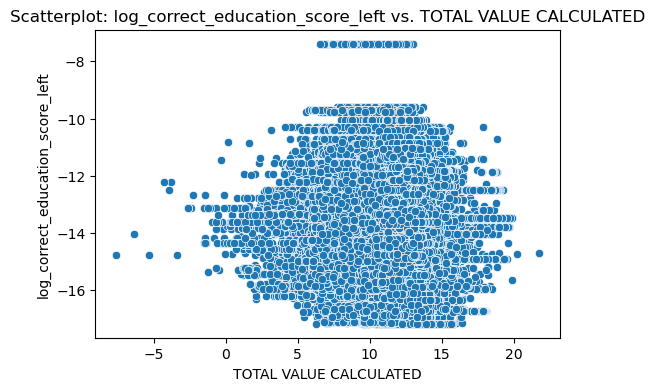

In [25]:
edu_col = "log_correct_education_score_left"
plt.figure(figsize=(6, 4))
sns.scatterplot(y=df_parcel_joined[edu_col], x=np.log(df_parcel_joined["total_value_calculated"]/df_parcel_joined["size_parcel"]))
plt.ylabel(edu_col)
plt.xlabel("TOTAL VALUE CALCULATED")
plt.title(f"Scatterplot: {edu_col} vs. TOTAL VALUE CALCULATED")
plt.show()

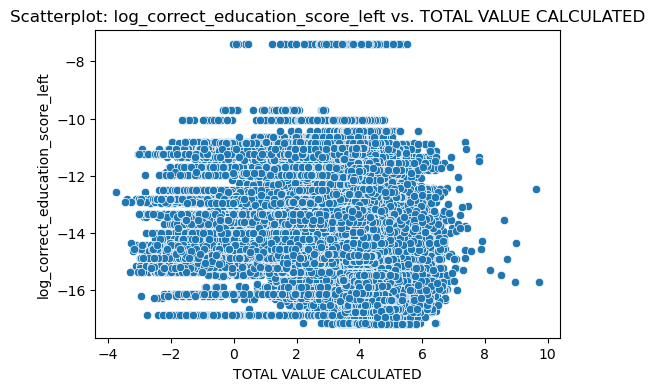

In [26]:
edu_col = "log_correct_education_score_left"
plt.figure(figsize=(6, 4))
sns.scatterplot(y=df_parcel_joined[edu_col], x=np.log(df_parcel_joined["total_value_calculated"]/df_parcel_joined["size_living"]))
plt.ylabel(edu_col)
plt.xlabel("TOTAL VALUE CALCULATED")
plt.title(f"Scatterplot: {edu_col} vs. TOTAL VALUE CALCULATED")
plt.show()

In [17]:
df_parcel_sample = df_parcel_joined.dropna().sample(n = 1000000, random_state = random_state)

In [19]:
X = df_parcel_sample[['distance', 'log_correct_education_score_school', 'log_correct_education_score_dist', 'block_level_longitude', 'block_level_latitude']]
y = np.log(df_parcel_sample["total_value_calculated"]/df_parcel_sample["size_parcel"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs = -1, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("Random Forest Regression with Log Transformed Target")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Random Forest Regression with Log Transformed Target
R² Score: 0.7613
Mean Absolute Error (MAE): 0.3749
Root Mean Squared Error (RMSE): 0.6086


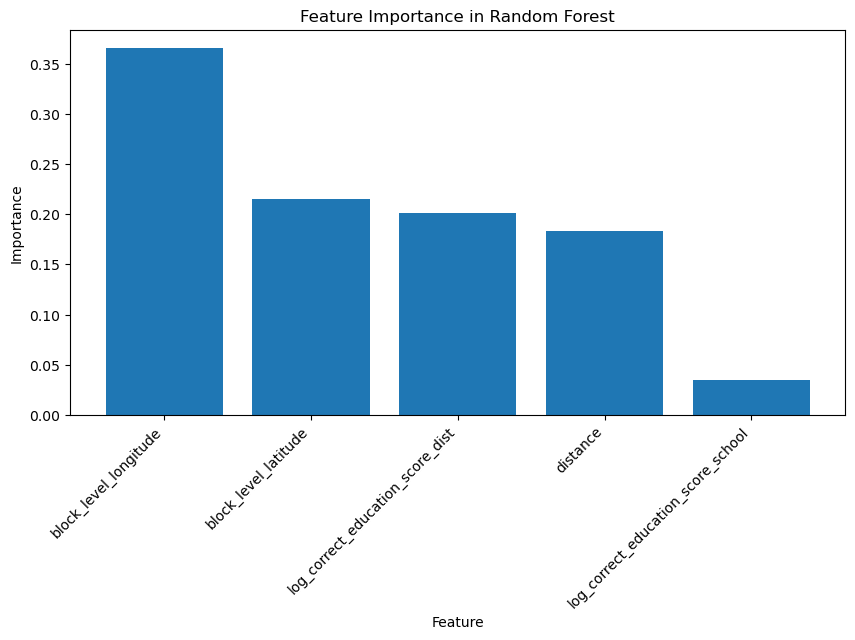

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()


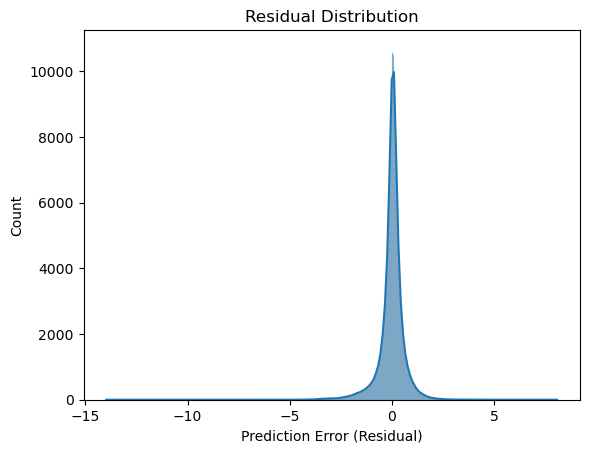

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Residual)")
plt.show()

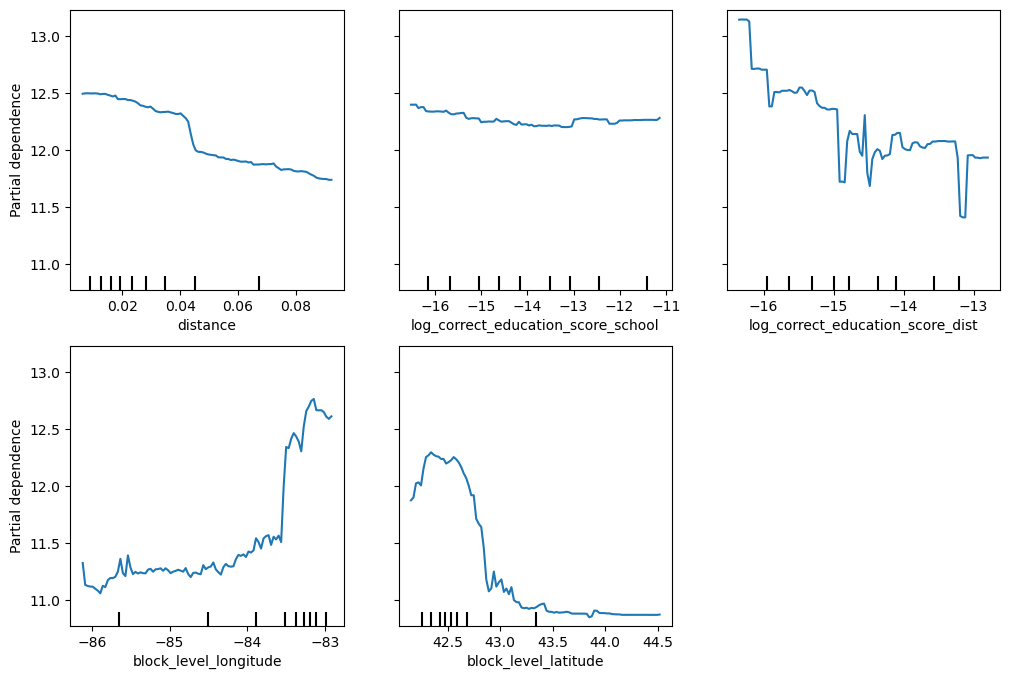

In [31]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Define figure size
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust width and height as needed

# Features to plot
features_to_plot = ['distance', 'log_correct_education_score_school', 'log_correct_education_score_dist', 'block_level_longitude', 'block_level_latitude']

# Generate PDPs with increased figure size
PartialDependenceDisplay.from_estimator(
    rf_model, 
    X.sample(n=100000, random_state=random_state), 
    features=features_to_plot, 
    kind='average',
    ax=ax  # Pass the customized figure size
)

plt.show()
